# Data Exploration

In [1]:
import json

In [2]:
data_annotation_path = "data/annotations.json"

In [3]:
with open(data_annotation_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [4]:
for key, value in data.items():
    print(f"{key}: {type(value)}")

info: <class 'dict'>
licenses: <class 'list'>
categories: <class 'list'>
annotations: <class 'list'>


In [5]:
for cat in data["categories"]:
    print(cat)

Human
Car
Truck
Van
Motorbike
Bicycle
Bus
Trailer


In [6]:
annotations = data["annotations"]

In [7]:
print(type(annotations[0]))

<class 'dict'>


In [8]:
for key, value in annotations[0].items():
    print(f"{key}: {value} {type(value)}")

image_name: frame_20190829091111_x_0001973.jpg <class 'str'>
image_width:: 1920.0 <class 'float'>
image_height: 1080.0 <class 'float'>
platform: Parrot Bebop 2 <class 'str'>
time: {'year': 2019, 'month': 8, 'day': 29, 'hour': 9, 'min': 11, 'sec': 11, 'ms': 394400.0} <class 'dict'>
longtitude: 10.18798203255313 <class 'float'>
latitude: 56.20630134795274 <class 'float'>
altitude: 19921.6 <class 'float'>
linear_x: 0.03130074199289083 <class 'float'>
linear_y: 0.028357808757573367 <class 'float'>
linear_z: 0.0744575835764408 <class 'float'>
angle_phi: -0.06713105738162994 <class 'float'>
angle_theta: 0.06894744634628296 <class 'float'>
angle_psi: 1.1161083340644837 <class 'float'>
bbox: [{'top': 163, 'left': 1098, 'height': 185, 'width': 420, 'class': 1}, {'top': 421, 'left': 1128, 'height': 176, 'width': 393, 'class': 1}, {'top': 927, 'left': 1703, 'height': 153, 'width': 183, 'class': 0}] <class 'list'>


In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame(annotations)

Checked if image width and heights are consistent

In [11]:
print(df["image_width:"].unique())
print(df["image_height"].unique())

[1920.]
[1080.]


In [12]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from PIL import ImageFont

# code is adapted from https://huggingface.co/facebook/detr-resnet-50
def get_model_and_processor():
        processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
        model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
        return model, processor

def get_results(image_path : str, model : DetrForObjectDetection = None, processor : DetrImageProcessor = None):
        if (model is None or processor is None):
                model, processor = get_model_and_processor()
        image = Image.open(image_path)
        inputs = processor(images=image, return_tensors="pt")
        outputs = model(**inputs)

        target_sizes = torch.tensor([image.size[::-1]])
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
        results["image_path"] = image_path
        results["label_names"] = [model.config.id2label[label.item()] for label in results["labels"]]
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
                box = [round(i, 2) for i in box.tolist()]
                print(
                        f"Detected {model.config.id2label[label.item()]} with confidence "
                        f"{round(score.item(), 3)} at location {box}"
                )
        return results

def draw_results(results):
    image = Image.open(results["image_path"])
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", size=64)
    except IOError:
        font = ImageFont.load_default()

    for score, label_name, box in zip(results["scores"], results["label_names"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        tl_x, tl_y, br_x, br_y = box
        draw.rectangle([tl_x, tl_y, br_x, br_y], outline="red", width=2)
        draw.text((tl_x, tl_y), f'{label_name}: {round(score.item(), 2)}', fill="red", font=font)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


c:\Users\USER\anaconda3\envs\di725-assignment-2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

Detected car with confidence 0.991 at location [1142.3, 191.85, 1497.37, 369.31]
Detected car with confidence 0.981 at location [1134.09, 426.04, 1507.74, 574.9]


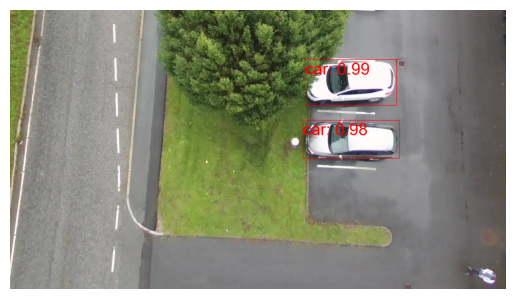

In [14]:

results = get_results("data/images/frame_20190829091111_x_0001973.jpg",model,processor)
draw_results(results)



Converted current annotations into a format that is compatible by what DETR requires

In [15]:
import json
import os

# Paths
images_dir = 'data/images'
annotations_file = 'data/annotations.json'
output_file = 'data/coco_compatible_annotations.json'

# Load custom annotations
with open(annotations_file, 'r') as f:
    data = json.load(f)

# Initialize COCO structure
coco = {
    'info': data.get('info', {}),
    'licenses': data.get('licenses', []),
    'images': [],
    'annotations': [],
    'categories': []
}

# Create category mapping
category_names = data['categories']
category_mapping = {idx: name for idx, name in enumerate(category_names)}
coco['categories'] = [{'id': idx, 'name': name} for idx, name in enumerate(category_names)]

# Process images and annotations
image_id = 1
for item in data['annotations']:
    file_name = item['image_name']
    width = int(item['image_width:'])
    height = int(item['image_height'])

    # Add image info
    coco['images'].append({
        'id': image_id,
        'file_name': file_name,
        'width': width,
        'height': height
    })

    # Add annotation info
    bboxes = []
    areas = []
    categories = []
    for bbox in item['bbox']:
        x = bbox['left']
        y = bbox['top']
        w = bbox['width']
        h = bbox['height']
        bboxes.append(
            [x,y,w,h]
            )

        areas.append(int(w * h))
        categories.append(bbox['class'])
    
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)


    coco['annotations'].append({
            'image_id': image_id,
            "annotations" : annotations 
        })    
    image_id += 1

# Save COCO annotations
with open(output_file, 'w') as f:
    json.dump(coco, f)


In [16]:
with open("data/coco_compatible_annotations.json", 'r') as f:
    data = json.load(f)

In [17]:
id2label = {item['id']: item['name'] for item in data['categories']}
label2id = {v: k for k, v in id2label.items()}

In [18]:
from transformers.image_utils import is_valid_annotation_coco_detection
is_valid_annotation_coco_detection(data["annotations"][0])

True

Dataset is loaded from the coco compatible annotations

In [19]:
from datasets import load_dataset
dataset = load_dataset('json', data_files='data/coco_compatible_annotations.json', field="annotations")

Generating train split: 32823 examples [00:00, 46148.85 examples/s]


As in the paper of AU-AIR dataset, the data is split into train, val, test with 0.6:0.1:0.3 ratio
https://arxiv.org/pdf/2001.11737

In [20]:
train_test_split = dataset['train'].train_test_split(test_size=0.4, shuffle=True, seed=2299436)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

val_test_split = test_dataset.train_test_split(test_size=0.25)
test_dataset = val_test_split['train']
val_dataset = val_test_split['test']

In [21]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['image_id', 'annotations'],
    num_rows: 19693
})
Dataset({
    features: ['image_id', 'annotations'],
    num_rows: 3283
})
Dataset({
    features: ['image_id', 'annotations'],
    num_rows: 9847
})


In [22]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Created a dictionary to get images from ids, instead of saving the images on memory

In [23]:
id_to_path = {entry['id']: "data/images/"+entry['file_name'] for entry in data["images"]}


In [24]:
def process_images(examples):
    images = []
    # for image_id in examples["image_id"]:
    #     image_path = id_to_path[image_id]
    #     image = Image.open(image_path)
    #     images.append(image)
    annotations = []

    for image_id, anns in zip(examples["image_id"], examples["annotations"]):
        image_path = id_to_path[image_id]
        image = Image.open(image_path).convert("RGB")
        images.append(image)

        annotations.append({
            "image_id": image_id,
            "annotations": anns
        })
    
    processed = image_processor(images=images, annotations=annotations, return_tensors="pt")
    processed.pop("pixel_mask", None)
    return processed

In [25]:
train_dataset_processed = train_dataset.with_transform(process_images)
val_dataset_processed = val_dataset.with_transform(process_images)

In [26]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

c:\Users\USER\anaconda3\envs\di725-assignment-2\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\USER\anaconda3\envs\di725-assignment-2\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\USER\anaconda3\envs\di725-assignment-2\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to

In [27]:
from transformers import TrainingArguments
from transformers import Trainer

import torch

output_dir = "output/detr-finetuned-auair"
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    max_steps=10000,
    fp16=True,
    save_steps=10,
    logging_steps=1,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    eval_steps=50,
    eval_strategy="steps",
    report_to="wandb",
    push_to_hub=True,
    batch_eval_metrics=True,
)

In [ ]:
import wandb

wandb.init(
    project="Assignment-2",
    name="detr-resnet-50-auair-finetuned",
    config=training_args,
)